In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def normalize_non_linear(images, avg_max_vals, beta=2.5):
    """Vectorized normalization from Arcelin et al. 2020 (Eq. 4)"""
    scaled = beta * images / avg_max_vals[:, None, None]
    return np.tanh(np.arcsinh(scaled))


def denormalize_non_linear(images_normed, avg_max_vals, beta=2.5):
    """Vectorized inverse normalization."""
    unscaled = np.sinh(np.arctanh(images_normed))
    return unscaled * avg_max_vals[:, None, None] / beta

In [3]:
folder = "../data/des_data"
save_path = "des_im3shape_images.npy"
id_list_path = "des_ids.npy"

all_data = []
all_ids = []
rng = np.random.default_rng(42)

for filename in sorted(os.listdir(folder)):
    if filename.endswith(".npy"):
        file_id = filename[:-4]
        filepath = os.path.join(folder, filename)
        arr = np.load(filepath)  # (5, 45, 45)

        # Original order: z, i, r, g, Y
        z = arr[0]
        i = arr[1]
        r = arr[2]
        g = arr[3]
        y = arr[4]
        u = rng.normal(0, 1, size=(45, 45))

        new_arr = np.stack([u, g, r, i, z, y], axis=0)  # (6, 45, 45)

        all_data.append(new_arr)
        all_ids.append(file_id)

# Convert to arrays
all_data = np.stack(all_data)  # (N, 6, 45, 45)
all_ids = np.array(all_ids)

# Save
np.save(save_path, all_data)
np.save(id_list_path, all_ids)

In [4]:
max_vals = np.max(all_data, axis=(2,3))
avg_max_vals = np.mean(max_vals, axis=0)

norm_des = normalize_non_linear(all_data, avg_max_vals)

np.save("des_avg_max_vals.npy", avg_max_vals)
np.save("des_im3shape_norm.npy", norm_des)
print(avg_max_vals)

[  3.45093315  34.25302746  95.29383035 172.92080667 241.33606618
 246.99201768]


In [5]:
np.load("../scripts/data_generation/sim_lsst_avg_max_vals.npy")

array([  259.75466 ,  2469.470075,  9002.368605, 10495.971575,
        8820.61493 ,  5511.4518  ])

In [6]:
norm_lsst = np.memmap("../scripts/data_generation/sim_lsst_norm_blended.npy", dtype=np.float32, mode="r", shape=(200000, 6, 45, 45))

In [9]:
norm_lsst_f = np.array(norm_lsst[:500])

In [20]:
band_names = ['u', 'g', 'r', 'i', 'z', 'Y']

lsst_flat = {}
des_flat = {}

for b in range(6):
    lsst_flat[band_names[b]] = np.hstack([
        norm_lsst_f[k][b].ravel() for k in range(norm_lsst_f.shape[0])
    ])
    
    des_flat[band_names[b]] = np.hstack([
        norm_des[k][b].ravel() for k in range(norm_des.shape[0])
    ])

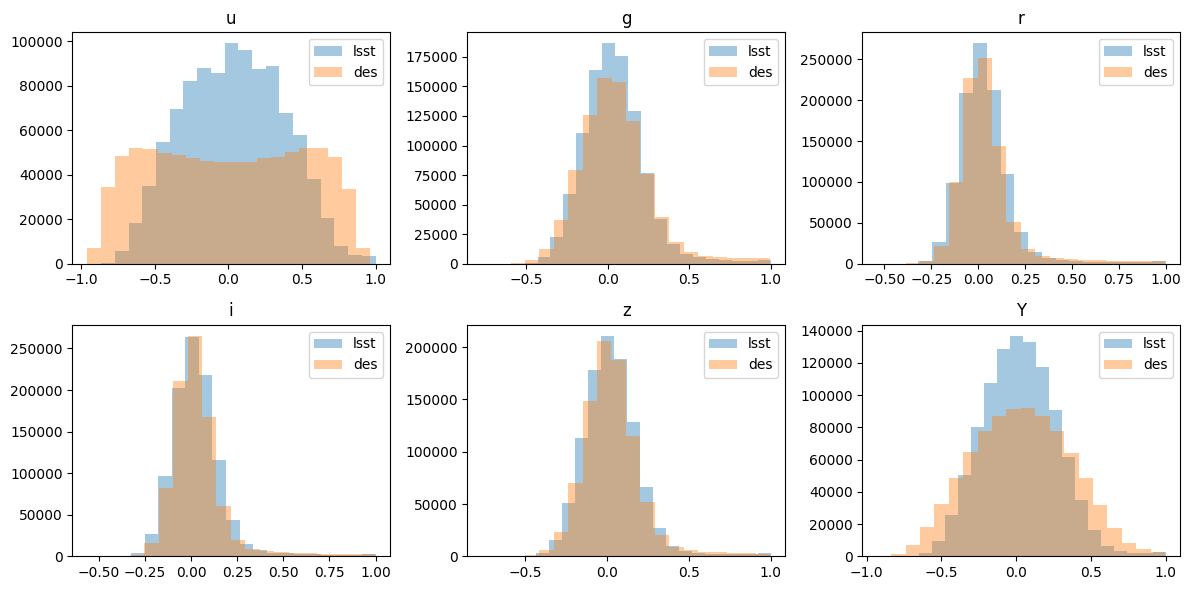

In [34]:
fig, ax = plt.subplots(2,3, figsize=(12,6))
ax[0, 0].hist(lsst_flat['u'], bins=20, alpha=0.4, label="lsst")
ax[0, 0].hist(des_flat['u'], bins=20, alpha=0.4, label="des")
ax[0, 0].set_title("u")
ax[0, 0].legend()

ax[0, 1].hist(lsst_flat['g'], bins=20, alpha=0.4, label="lsst")
ax[0, 1].hist(des_flat['g'], bins=20, alpha=0.4, label="des")
ax[0, 1].set_title("g")
ax[0, 1].legend()

ax[0, 2].hist(lsst_flat['r'], bins=20, alpha=0.4, label="lsst")
ax[0, 2].hist(des_flat['r'], bins=20, alpha=0.4, label="des")
ax[0, 2].set_title("r")
ax[0, 2].legend()

ax[1, 0].hist(lsst_flat['i'], bins=20, alpha=0.4, label="lsst")
ax[1, 0].hist(des_flat['i'], bins=20, alpha=0.4, label="des")
ax[1, 0].set_title("i")
ax[1, 0].legend()

ax[1, 1].hist(lsst_flat['z'], bins=20, alpha=0.4, label="lsst")
ax[1, 1].hist(des_flat['z'], bins=20, alpha=0.4, label="des")
ax[1, 1].set_title("z")
ax[1, 1].legend()

ax[1, 2].hist(lsst_flat['Y'], bins=20, alpha=0.4, label="lsst")
ax[1, 2].hist(des_flat['Y'], bins=20, alpha=0.4, label="des")
ax[1, 2].set_title("Y")
ax[1, 2].legend()

plt.tight_layout()
plt.savefig("images/dynamical_range")